In [19]:
from functools import partial
import sys
sys.path.append('../CNN')

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision import transforms
from torchvision.datasets import FashionMNIST
import torch
import torch.optim as optim
import torch.nn as nn

import utils

# 画像系の復習はここに

In [20]:
conv_model = nn.Sequential(
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(128, 10)
)
    

In [21]:
conv_model

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=128, out_features=10, bias=True)
)

In [22]:
for name, module in conv_model.named_modules():
    print(name)


0
1
2
3
4
5
6
7
8
9


In [23]:
# GAP層　動き確認
X =  torch.randn(8, 64, 4, 4)
X = nn.AdaptiveAvgPool2d(1)(X)
print(X.shape) # [8, 1, 1]

out = nn.Flatten()(X) # [8, 64]
out.shape

torch.Size([8, 64, 1, 1])


torch.Size([8, 64])

### hook

In [24]:
a = torch.ones(5, requires_grad=True)
b = 2 * a
b.retain_grad() # 中間層の勾配
b.register_hook(lambda grad : print(grad))
c = b.mean()
c.backward()

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


### .register.forward_hook

In [25]:
outputs = {}
def save_output(module, inp, out, name):
    module_name = f"{name}_{str(module)}"
    outputs[module_name] = out.shape

In [26]:
# .register_forward_hookを付ける
for name, module in conv_model.named_modules():
    if name:
        module.register_forward_hook(partial(save_output, name=name))
# .register_full_backward_hookを付ける(後ろにあるsave_gradsを先に実行)
for name, module in conv_model.named_modules():
    if name:
        module.register_full_backward_hook(partial(save_grads, name=name))

In [27]:
def print_hooks(model):
    """
    forward時に出力サイズを記録する関数
    """
    for name, module in model.named_modules():
        if hasattr(module, '_forward_hooks'):
            for hook in module._forward_hooks.values():
                print(f"Module {name} has forward hook {hook}.")
        if hasattr(module, '_backward_hooks'):
            for hook in module._backward_hooks.values():
                print(f"Module {name} has backward hook {hook}.")                

In [28]:
print_hooks(conv_model)

Module 0 has forward hook functools.partial(<function save_output at 0x7f759cdceaf0>, name='0').
Module 0 has backward hook functools.partial(<function save_grads at 0x7f74dcbefa60>, name='0').
Module 1 has forward hook functools.partial(<function save_output at 0x7f759cdceaf0>, name='1').
Module 1 has backward hook functools.partial(<function save_grads at 0x7f74dcbefa60>, name='1').
Module 2 has forward hook functools.partial(<function save_output at 0x7f759cdceaf0>, name='2').
Module 2 has backward hook functools.partial(<function save_grads at 0x7f74dcbefa60>, name='2').
Module 3 has forward hook functools.partial(<function save_output at 0x7f759cdceaf0>, name='3').
Module 3 has backward hook functools.partial(<function save_grads at 0x7f74dcbefa60>, name='3').
Module 4 has forward hook functools.partial(<function save_output at 0x7f759cdceaf0>, name='4').
Module 4 has backward hook functools.partial(<function save_grads at 0x7f74dcbefa60>, name='4').
Module 5 has forward hook func

### forward hook が正しく出来ているか確認

In [29]:
X = torch.randn(3, 1, 28, 28)
out = conv_model(X) # ここでshapeが記録される
outputs

{'0_Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([3, 4, 14, 14]),
 '1_ReLU()': torch.Size([3, 4, 14, 14]),
 '2_Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([3, 8, 7, 7]),
 '3_ReLU()': torch.Size([3, 8, 7, 7]),
 '4_Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([3, 16, 4, 4]),
 '5_ReLU()': torch.Size([3, 16, 4, 4]),
 '6_Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([3, 32, 2, 2]),
 '7_ReLU()': torch.Size([3, 32, 2, 2]),
 '8_Flatten(start_dim=1, end_dim=-1)': torch.Size([3, 128]),
 '9_Linear(in_features=128, out_features=10, bias=True)': torch.Size([3, 10])}

### .register.full_backward_hook

In [30]:
grads = {}
def save_grads(module, grad_in, grad_out, name):
    """
    逆伝播の入力を記録する関数
    """
    module_name = f"{name}_{str(module)}"
    grads[module_name] = grad_in

### register_full_backward_hookが正しく出来ているか確認

In [31]:
loss = out.mean()
loss.backward()
grads

{'9_Linear(in_features=128, out_features=10, bias=True)': (tensor([[-1.5084e-03,  4.1747e-05,  5.9940e-03, -9.2793e-03,  1.3051e-03,
           -5.7475e-03, -2.8917e-03,  7.1465e-03, -5.5394e-03,  4.5740e-03,
            3.2204e-03, -3.3565e-03,  9.5257e-04,  1.3759e-02,  1.7352e-03,
           -3.8220e-03,  5.4546e-03, -7.7369e-04, -6.9751e-04, -2.2421e-03,
           -6.5936e-04, -2.9339e-03,  2.4246e-03,  2.7600e-03,  2.4953e-03,
            7.9355e-04, -2.2789e-03, -3.7408e-03,  1.2363e-03,  4.2284e-03,
            4.9890e-03, -3.1881e-03,  4.0194e-03, -1.2628e-04,  1.2021e-02,
            5.2281e-04, -3.6292e-04, -4.9090e-03,  1.8918e-03,  1.3027e-03,
            2.5094e-03, -5.3422e-03, -3.4311e-03, -5.7483e-03, -7.0740e-03,
           -2.5143e-03,  6.1651e-03, -5.5839e-03,  6.1617e-03,  6.3931e-03,
            2.9302e-03, -4.9073e-03, -4.2902e-03, -3.4648e-03, -5.4668e-04,
            2.1043e-04,  3.8909e-03, -2.4420e-03,  8.2323e-03, -1.9081e-03,
            1.5396e-03, -1.2449

### Activation分布

In [32]:
act_means = [[] for module in conv_model if isinstance(module, nn.ReLU)]
act_stds = [[] for module in conv_model if isinstance(module, nn.ReLU)]
relu_layres = [module for module in conv_model if isinstance(module, nn.ReLU)]


def save_statistics(i, module, inp, out):
    act_means[i].append(out.detach().cpu().mean())
    act_stds[i].append(out.detach().cpu().std())

for i, relu in enumerate(relu_layres):
    relu_layres[i].register_forward_hook(partial(save_statistics, i))

In [33]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5))
])

train_dataset = FashionMNIST('../CNN/fmnist_data', train=True, download=True, transform=transform)
val_dataset = FashionMNIST('../CNN/fmnist_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)
val_loader = DataLoader(train_dataset, batch_size=1024, shuffle=False, num_workers=4)

opt = optim.SGD(conv_model.parameters(), lr=0.6)

train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)


epoch: 0: train error: 2.1693764803773266, validation error: 1.7983506897748527, validation accuracy: 0.3700483663607452


epoch: 1: train error: 1.2724957203460951, validation error: 0.8510258308911728, validation accuracy: 0.703103221068948


epoch: 2: train error: 0.7725689199011204, validation error: 0.7399203413623875, validation accuracy: 0.7149996868634628


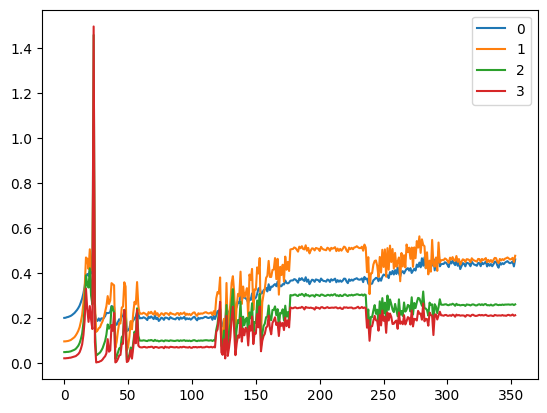

In [34]:
for act_mean in act_means:
    plt.plot(act_mean)

plt.legend(range(len(act_means)))

### クラス化

In [73]:
class ActivationStatistics():
    def __init__(self, sequential_model):
        self.model = sequential_model
        self.act_means = [[] for module in self.model if isinstance(module, nn.ReLU)]
        self.act_stds = [[] for module in self.model if isinstance(module, nn.ReLU)]
        self.relu_layers = [module for module in self.model if isinstance(module, nn.ReLU)]
        self._register_forward_hook()

    def _register_forward_hook(self):
        for i, relu_module in enumerate(self.relu_layers):
            relu_module.register_forward_hook(partial(self._save_activation, i=i))

    def _save_activation(self, module, inp, out, i):
        if self.model.training: # 訓練中のみ適用させる
            self.act_means[i].append(out.detach().cpu().mean().item())
            self.act_stds[i].append(out.detach().cpu().std().item())

    def get_activations(self):
        
        return self.act_means, self.act_stds

    def plot_statistics(self):
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        for act_mean in self.act_means:
            ax[0].plot(act_mean)
        for act_std in self.act_stds:
            ax[1].plot(act_std)

        ax[0].set(
            title = 'Activations of mean'
        )
        ax[0].legend(range(len(self.act_means)))
        ax[1].set(
            title = 'Activations of std'
        )
        ax[1].legend(range(len(self.act_stds)))
                     
        plt.show()
            
            
        
        

In [74]:
conv_model = nn.Sequential(
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(128, 10)
)
    
act = ActivationStatistics(conv_model)
opt = optim.SGD(conv_model.parameters(), lr=0.6)
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 2.177114933224048, validation error: 1.8536386368638378, validation accuracy: 0.44573239552772653


epoch: 1: train error: 1.0986002006773221, validation error: 1.0022416195626986, validation accuracy: 0.6262727541438604


epoch: 2: train error: 0.710746947991646, validation error: 0.5999102016626778, validation accuracy: 0.7814886963973611


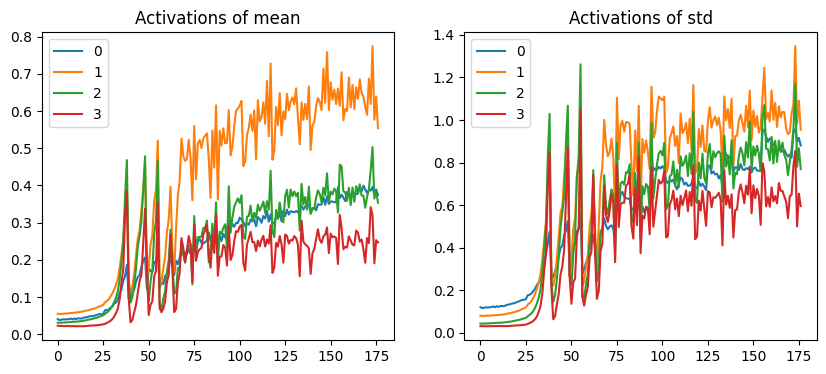

In [75]:
act.plot_statistics()